In [1]:
from transformers import GPT2Tokenizer, GPTNeoForCausalLM
from transformers import pipeline
import torch
import os
import numpy as np
from tqdm import tqdm

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-2.7B")
model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-2.7B")


In [3]:
device = torch.device('cuda:7')
model.to(device)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2560)
    (wpe): Embedding(2048, 2560)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (v_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (q_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
          )
        )
        (ln_2): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2560, out_features=10240, bias=True)
          (c_proj): Linear(in_fe

In [4]:
# generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device = 6)
# test_s = "1) Barack Obama was born in Honolulu.\n2) Angela Merkel was born in Berlin.\n3) John Lennon was born in liverpool\n4) Donald Trump was born in New York\n5) Joe Biden was born in Pennsylvania\n6) Clinton was born in"
# print(test_s)
# len(tokenizer.tokenize(test_s))
# generated = generator(test_s, do_sample=True, max_length=10)
# print(generated[0]["generated_text"])

In [5]:
import datetime
import csv
s_list = []
with open('birth_table1.tsv', 'r') as t:
    i = 0
    # sentences_birth = open("sentences_birth.tsv", "w")
    # tsv_writer = csv.writer(sentences_birth, delimiter='\t')

    for line in t:
        i+=1
        if i==1:
            continue
        
        person, mother, place, date = line.split('\t')
        if len(mother) == 0:
            continue
        def process(raw):
            raw = raw.split("@")
            content, lang = raw
            content = content.strip("''").split()
            return content, lang

        person, lang = process(person)
        if lang != "en":
            continue
        mother, lang = process(mother)
        if lang != "en":
            continue        
        place, lang = process(place)
        if lang != "en":
            continue
        
        sentence = person + ["was", "born", "in"] + place + ['.']
        sentence = " ".join(sentence)
        s_place = " ".join(place)
        s_list.append("\t".join([sentence, s_place]))
        # print("person: ", person,  "mother: ", mother, "place: ", place, "date: ", date, len(place), len(date))
        # “[MOTHER] gave birth to [PERSON] at [PLACE] on [DATE]” 

        # idx = 0
        # spans = []
        # spans.append([idx, idx + len(mother) - 1])
        # idx+=len(mother) + 3
        # spans.append([idx, idx + len(person) - 1])
        # idx+=len(person) + 1
        # spans.append([idx, idx + len(place) - 1])
        # idx+=len(place) + 1

        # date = date.split('T')[0][1:]
        # year, month, day = date.split('-')
        # year = int(year)
        # month = int(month)
        # day = int(day)
        # d = datetime.date(year, month, day)
        # date = d.strftime("%d %B %Y").split()
        # spans.append([idx, idx + 2])
        
        # s = mother + ["gave", "birth", "to"] + person + ["at"] + place + ["on"] + date + ["."]
        # s = " ".join(s)
        # for span in spans:
        #     tsv_writer.writerow([str(span[0]) + " " +  str(span[1])] + [s])
        # print(spans)
        # print(s)
        # if i>10:
        #     breaks
    # sentences_birth.close()
    # print(i)

In [6]:
# prompt = (
#     "In a shocking finding, scientists discovered a herd of unicorns living in a remote, "
#     "previously unexplored valley, in the Andes Mountains. Even more surprising to the "
#     "researchers was the fact that the unicorns spoke perfect English."
# )
# input_ids = tokenizer(prompt, return_tensors="pt").input_ids
# input_ids = input_ids.to(device)
# gen_output = model.generate(
#     input_ids,
#     # do_sample=True,
#     # temperature=0.9,
#     max_length=60,
#     return_dict_in_generate = True,
#     output_scores = True
# )
# gen_tokens = gen_output.sequences
# gen_scores = gen_output.scores
# gen_text = tokenizer.batch_decode(gen_tokens)[0]
# print(gen_text)

In [7]:
class MeanReciprocalRank:
    def __init__(self):
        self._sum = 0.0
        self._n = 0.0

    def __call__(self, predictions, labels):
        # Flatten
        labels = labels.view(-1)
        
        predictions = predictions.view(labels.shape[0], -1)

        
        # MRR computation
        label_scores = predictions.gather(-1, labels.unsqueeze(-1))
        rank = predictions.ge(label_scores).sum(1).float()
        # print(rank)
        reciprocal_rank = 1 / rank
        self._sum += (reciprocal_rank).sum().item()
        self._n += len(labels)

    def get_metric(self, reset=False):
        mrr = self._sum / (self._n + 1e-13)
        if reset:
            self.reset()
        return mrr
    def reset(self):
        self._sum = 0.0
        self._n = 0.0
class Hits:
    def __init__(self, topn):
        self.topn = topn
        self._sum = 0.0
        self._n = 0.0

    def __call__(self, predictions, labels):
        # Flatten
        labels = labels.view(-1)

        predictions = predictions.view(labels.shape[0], -1)


        # MRR computation
        label_scores = predictions.gather(-1, labels.unsqueeze(-1))
        rank = predictions.ge(label_scores).sum(1).float()
        # reciprocal_rank = 1 / rank
        score = rank.le(self.topn).float()
        self._sum += (score).sum().item()
        self._n += len(labels)

    def get_metric(self, reset=False):
        hits = self._sum / (self._n + 1e-13)
        if reset:
            self.reset()
        return hits

    def reset(self):
        self._sum = 0.0
        self._n = 0.0


In [15]:
import random
sample_num = 6

f = open("generated.txt", 'w')
mrr = MeanReciprocalRank()
hits = Hits(50)
total_ranks = []
for _ in tqdm(range(10000)):
    sample_ids = random.sample(range(len(s_list)), sample_num)
    sample = ""
    place_final = ""
    for i, sample_id in enumerate(sample_ids):
        sentence, place = s_list[sample_id].split('\t')
        words, len_place = sentence.split(), len(place.split())
        if i == sample_num-1:
            place_final = place
            sentence = "{})".format(i+1) + " ".join(words[:-1-len_place])
        else:
            sentence = "{})".format(i+1) + " ".join(words) + '\n'
        sample += sentence
    # input_ids = len(tokenizer.tokenize(sample))
    # generated_text = generator(sample, do_sample=True, max_length=input_ids+5)[0]["generated_text"]
    input_ids = tokenizer(sample, return_tensors="pt").input_ids
    input_ids = input_ids.to(device)

    place_ids = tokenizer(place_final, return_tensors="pt").input_ids
    place_ids = place_ids.to(device)
    max_new_tokens = place_ids.shape[1]


    gen_output = model.generate(
    input_ids,
    # do_sample=True,
    # temperature=0.9,
    max_new_tokens = max_new_tokens,
    # max_length = 100,
    return_dict_in_generate = True,
    output_scores = True,
    pad_token_id = model.config.eos_token_id
)
    gen_tokens = gen_output.sequences
    gen_scores = gen_output.scores
    gen_text = tokenizer.batch_decode(gen_tokens)[0]
    print(gen_text, file = f)
    print(place_final, file = f)
    
    gen_scores = torch.stack(list(gen_scores), dim=0).squeeze(1)

    mrr(gen_scores, place_ids)
    
    
    hits(gen_scores, place_ids)
    

    ranks = torch.argsort(gen_scores, dim = 1, descending=True)
    ranks = torch.argsort(ranks, dim = 1)
    gen_ranks = [ranks[i][id].item() for i, id in enumerate(place_ids[0])]
    total_ranks += gen_ranks
    gen_ranks = list(map(str, gen_ranks))
    gen_ranks = ",".join(gen_ranks)
    print(gen_ranks, file = f)

f.close()
print(mrr.get_metric())
print(hits.get_metric())
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [15:02<00:00, 11.08it/s]

0.027998542261428207
0.058398392208394524


In [20]:
len(total_ranks)

25874

<IPython.core.display.Javascript object>


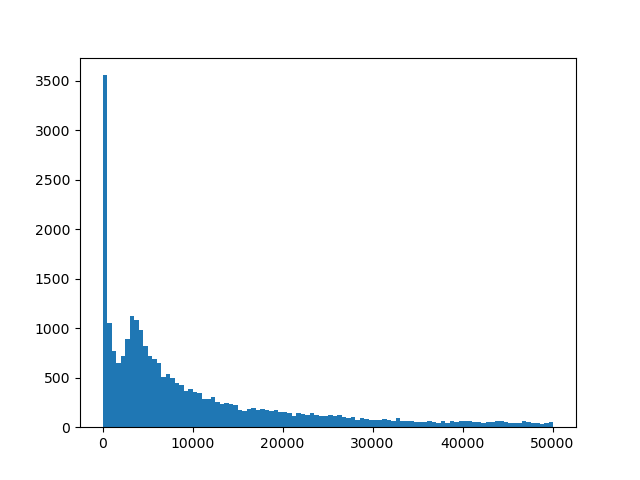

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.hist(total_ranks, bins = 100)
plt.show()

In [11]:
print(torch.argmax(gen_scores, dim = 1))
print(place_ids)
rank = torch.argsort(gen_scores, dim = 1, descending=True)
rank = torch.argsort(rank, dim = 1)


tensor([ 968, 1971, 2254], device='cuda:7')
tensor([[ 2484, 36955,   634]], device='cuda:7')


In [26]:
[rank[i][id].item() for i, id in enumerate(place_ids[0])]

[9842, 20013, 823]